<a href="https://colab.research.google.com/github/DataMastersUN/FA_T3/blob/main/Trabajo_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# **Fundamentos de Analítica**

##**Trabajo 3: Clasificación de Imágenes**

Integrantes:

David Antonio Castro Tamayo
dcastrot@unal.edu.co

Luis Javier Asprilla Galarcio
lasprilla@unal.edu.co

Anderson Elian Gutierrez Bueno
angutierrezb@unal.edu.co

</center>

Se tiene un conjunto de imágenes de personas con y sin gafas, en las que los individuos aparecen con diferentes expresiones faciales y ángulos, descargado de la fuente:https://archive.ics.uci.edu/ml/datasets/CMU+Face+Images

Objetivo: Construir y validar un modelo de aprendizaje estadístico para clasificar imágenes de sujetos con gafas del conjunto de datos dado.

In [3]:
# Librerias usadas
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import itertools
import math
import os
import pickle
from sklearn.metrics import confusion_matrix
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from random import randint, choice, choices
from tensorflow import keras
from PIL import Image
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import cv2
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Activation, BatchNormalization

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ancho, alto = imagen.size
#print(f"Tamaño de la imagen: {ancho}x{alto}")

# También puedes acceder a los píxeles de la imagen
#pixeles = list(imagen.getdata())
#print(f"Primer píxel: {pixeles[0]}")

# Cierra la imagen
#imagen.close()

In [42]:
#CODIGO INICIAL PARA AÑADIR TODAS LAS IMAGENES A UN LISTA ESTÁTICA, Y ASÍ NO TENER QUE CARGAR TODAS LAS IMÁGENES CADA VEZ QUE SE EJECUTE EL CÓDGO

# Ruta a la carpeta raíz que contiene las subcarpetas con las imágenes PGM
ruta_raiz = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/faces_4'
rutas_imagenes = []
# Recorre las subcarpetas y busca las imágenes PGM
for directorio_raiz, directorios, archivos in os.walk(ruta_raiz):
    for archivo in archivos:
        if archivo.lower().endswith('.pgm'):
            # Construye la ruta completa al archivo
            ruta_completa = os.path.join(directorio_raiz, archivo)
            rutas_imagenes.append(ruta_completa)
# Ahora tienes todas las rutas de las imágenes PGM en la lista rutas_imagenes
# Puedes cargar las imágenes si es necesario

etiquetas = [ruta.split('_')[-2].split('.')[0] for ruta in rutas_imagenes]

# Para verificar la cantidad de imágenes

# Para acceder a una imagen específica
print(etiquetas[:10])

'open'

In [ ]:
# Ruta en tu Google Drive donde guardar el archivo
"""ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/imagenes.pkl'
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(imagenes, archivo)"""

In [4]:
ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/imagenes.pkl'

with open(ruta_archivo, 'rb') as archivo:
    images = pickle.load(archivo)
print(f'Se encontraron {len(images)} imágenes PGM.')

Se encontraron 624 imágenes PGM.


In [5]:
images[45].shape

(30, 32, 3)

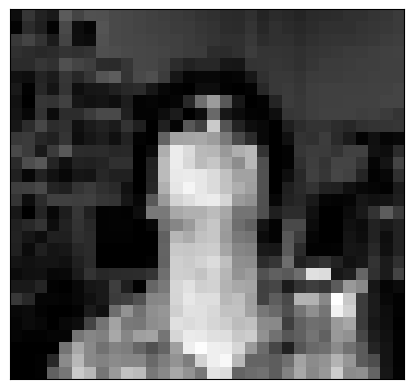

In [6]:
imagen = Image.open('/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/faces_4/an2i/an2i_up_sad_sunglasses_4.pgm')

plt.imshow(imagen, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

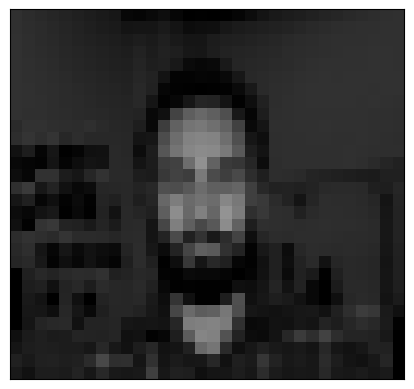

In [ ]:
plt.imshow(images[134], cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
images[7].shape

(30, 32, 3)

In [ ]:
imagen_prueba = cv2.cvtColor(images[134], cv2.COLOR_BGR2GRAY)
imagen_prueba.shape

(30, 32)

In [ ]:
imagen_prueba

Representación de una matriz que describe los valores de los píxeles en una imagen en blanco y negro. Cada número en la matriz corresponde al valor del píxel en esa posición en la imagen.

Los números en la matriz representan los niveles de gris de cada píxel en la imagen en blanco y negro.
Los valores suelen estar en el rango de 0 a 255, donde 0 representa negro y 255 representa blanco, y los valores intermedios representan tonos de gris.
La matriz se forma de tal manera que cada fila y columna representa un píxel en la imagen. Por ejemplo, el valor en la posición (0, 0) de la matriz representa el nivel de gris del píxel en la esquina superior izquierda de la imagen, y el valor en la posición (30, 32) representa el píxel en la esquina inferior derecha de la imagen.
Esta matriz se utiliza para almacenar la información de intensidad de los píxeles en la imagen en blanco y negro. Puedes procesar y analizar esta matriz para realizar diversas operaciones en la imagen.

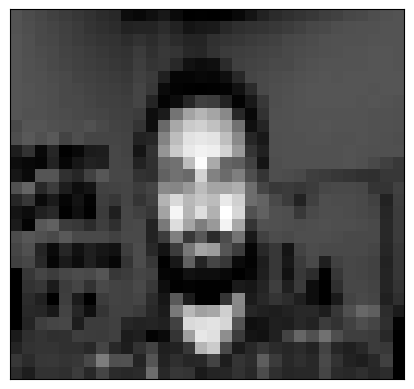

In [ ]:
plt.imshow(imagen_prueba, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

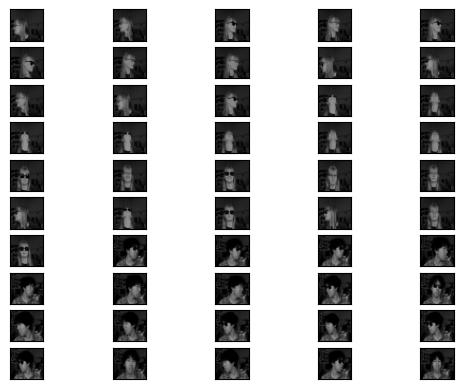

In [ ]:
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
# Convirtamos las imágenes en vectores y luego construimos una matriz
# con estos vectores como filas
img_vectorizadas = [i.flatten() for i in images]
imagenes_matriz = np.vstack(img_vectorizadas)
imagenes_matriz = imagenes_matriz-imagenes_matriz.mean()
print(imagenes_matriz.shape)

(624, 2880)


Esta función

In [ ]:
# Calculemos la matriz de correlación:
S = np.corrcoef(imagenes_matriz.T)
print(S.shape)

(2880, 2880)


In [ ]:
for i in range(2):
    tipo = type(images[i])
    print(f"Elemento: {images[i]}, Tipo: {tipo}\n\n")

In [30]:
#transformacion real a grises
images_gray = []
for i in range(len(images)):
    image = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    images_gray.append(image)

images_gray[4].shape

(30, 32)

In [31]:
#Redimensión de todas las imagenes a un tamaño estandar
new_height = images[0].shape[0]
new_width = images[0].shape[1]
images_proc = []
for i in range(len(images_gray)):
    image = cv2.resize(images_gray[i],(new_width, new_height))
    images_proc.append(image)

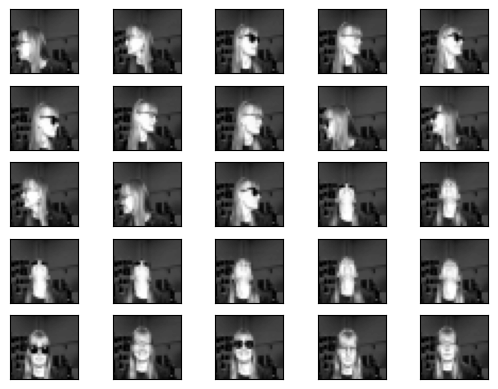

In [32]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images_proc[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [34]:
#Normalización de pixeles dividiendo cada valor de píxel por el valor máximo posible (255 en el caso de imágenes en escala de grises).
#Esto normalizará los valores de píxeles en el rango de [0, 1].
images_normalized = []
for i in range(len(images_proc)):
    image = images_proc[i] / 255.0
    images_normalized.append(image)

In [37]:
#Partición de los datos en train, test, y validation
train_data, temp_data = train_test_split(images_proc, test_size=0.3, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Aquí, X_train y X_test son iguales a train_data y test_data, respectivamente
X_train, X_test = train_data, test_data

## Declaración de labels y análisis de datos

*X_train*: Variable de imagenes de entrenamiento.

*y_train*: Label que asigna el tipo de clase de imagenes de entrenamiento.

*X_valid*: Variable de imagenes de validación.

*y_valid*: Label que asigna el tipo de clase de las imagenes de validación.

*X_test*: Variable de imagenes de prueba.

*y_test*: Label que asigna el tipo de clase de las imagenes de prueba.

**Clasifiación de especies de monos**:

<center>